In [60]:
import tarfile
import pandas as pd
import os

Import Data to DataFrame, include Benign/Malignant with ID, Choose a Magnification

In [61]:
def extract_image_labels(folder_path, magnification_lvl): 
    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == str(magnification_lvl):
                    labels.append(label)
                    file_paths.append(file_path)
    
    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df

In [62]:
image_labels_df = extract_image_labels("C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1", 40) # change mangification level here


In [63]:
image_labels_df.head(5)

,FilePath,Label
0,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
1,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
2,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
3,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
4,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B


Split Data

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1396, 2)
The shape of test data (299, 2)
The shape of validation data (300, 2)


In [66]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

Visualize Distribution of Train, Test, Validation Data

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

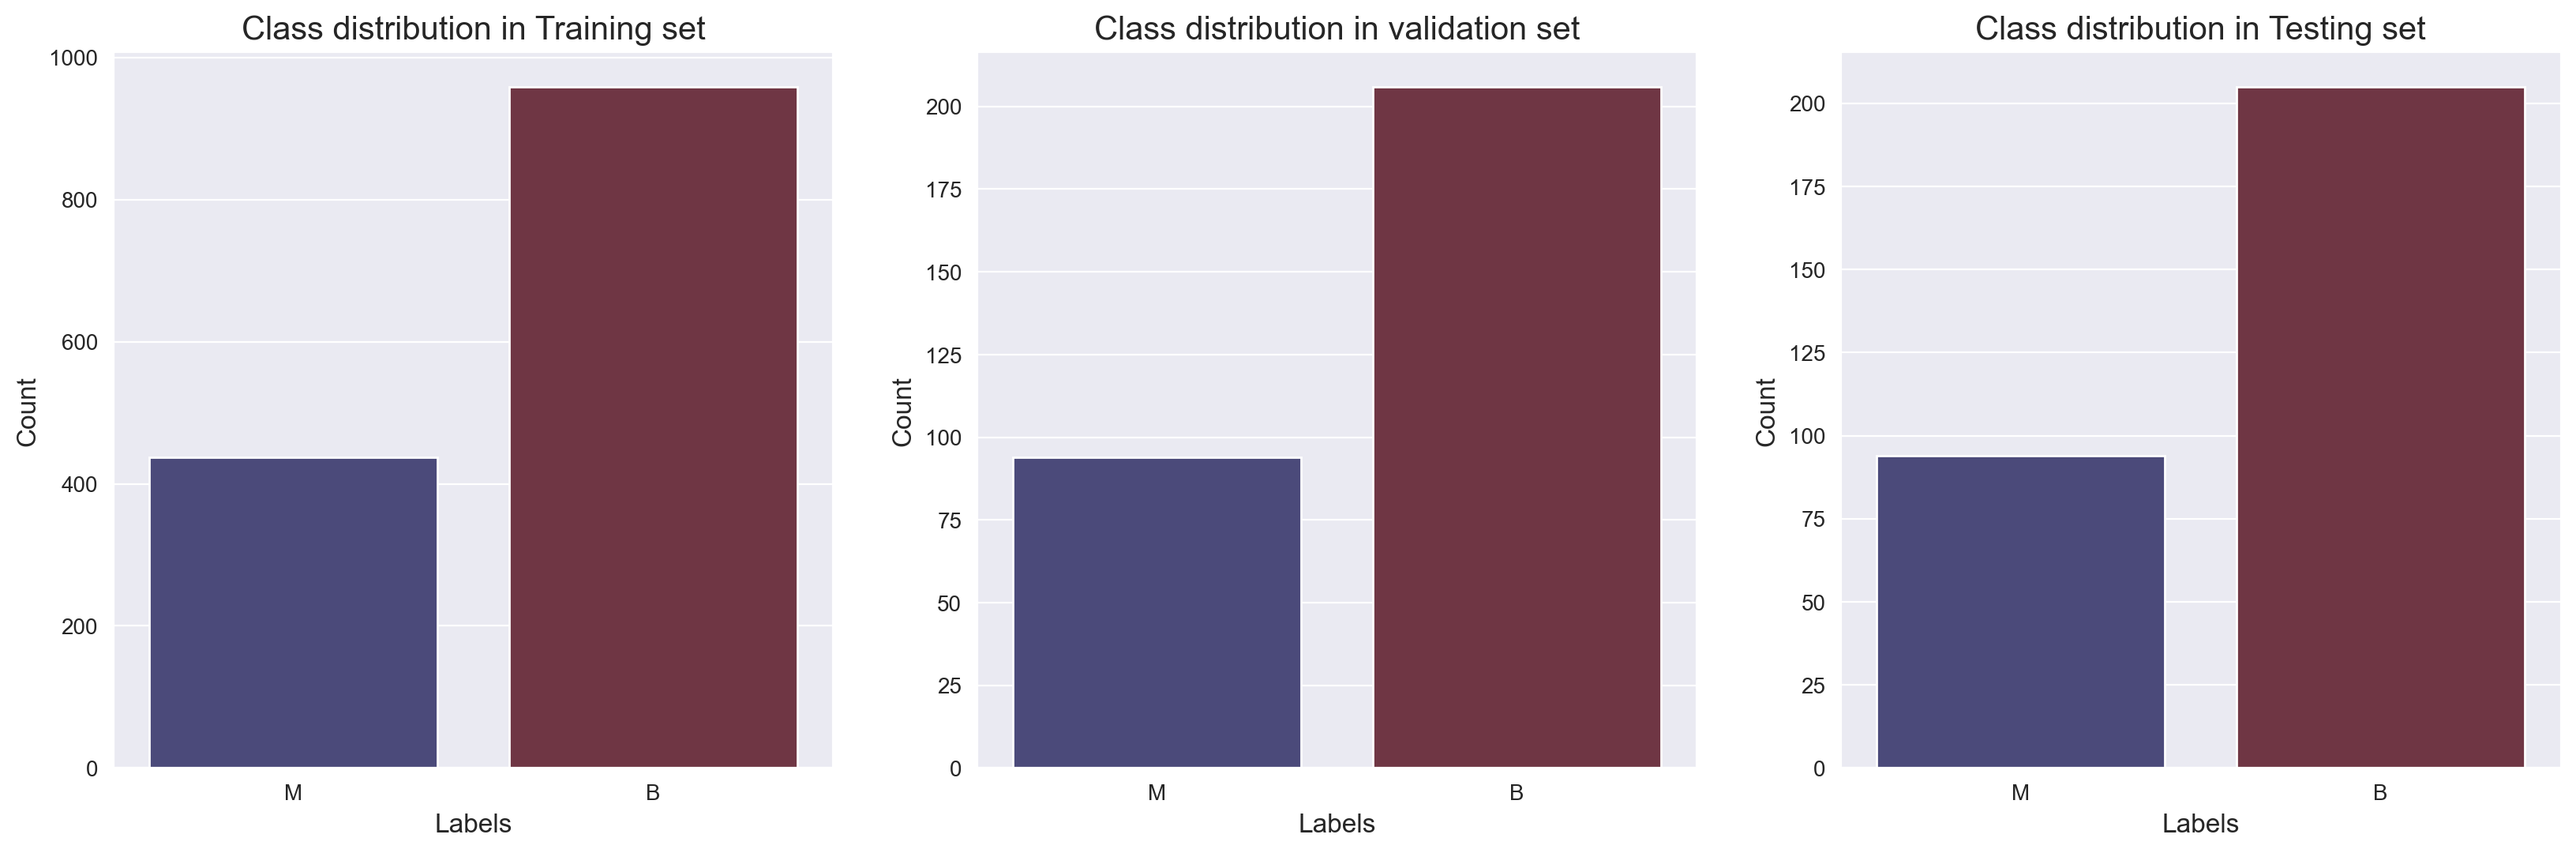

In [68]:
labels = ['M','B']

label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire').set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire').set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire').set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

Implement at least three Deep Learning based classifiers: One needs to be a CNN, one can be a shallow neural network, e.g. a fully connected NN with one hidden layer.

In [69]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall


CNN

In [70]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [71]:
base_dir = "C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1"

In [72]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

Data Augmentation

In [73]:
# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),        # Rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.2),            # Zoom up to 20%
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

In [74]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = (create_dataset(train_filepaths, train_labels)
            .shuffle(buffer_size=len(train_filepaths))
            .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.experimental.AUTOTUNE))
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [75]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

c:\Users\igali\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [77]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6838 - loss: 0.6252 - precision_3: 0.6868 - recall_3: 0.9892 - val_accuracy: 0.6867 - val_loss: 0.5748 - val_precision_3: 0.6867 - val_recall_3: 1.0000
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7255 - loss: 0.5703 - precision_3: 0.7292 - recall_3: 0.9604 - val_accuracy: 0.7867 - val_loss: 0.5042 - val_precision_3: 0.7710 - val_recall_3: 0.9806
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7843 - loss: 0.4914 - precision_3: 0.7962 - recall_3: 0.9221 - val_accuracy: 0.7567 - val_loss: 0.5028 - val_precision_3: 0.7436 - val_recall_3: 0.9854
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7696 - loss: 0.5136 - precision_3: 0.7711 - recall_3: 0.9367 - val_accuracy: 0.8033 - val_loss: 0.4715 - val_precision_3: 0.7838 - val_recall_3: 0.9854
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7582 - loss: 0.5235 - precision_3: 0.7714 - recall_3: 0.9156 - val_

Evaluation

In [78]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8184 - loss: 0.4615 - precision_3: 0.8646 - recall_3: 0.8754
Loss: 0.4470570981502533
Accuracy: 0.829431414604187
Precision: 0.8598130941390991
Recall(Sensitivity): 0.8975609540939331
